# RNNs

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd
import json
import hyperopt

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation, Activation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense, BatchNormalization
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer, Optimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule
from grad_check import eval_numerical_gradient, eval_numerical_gradient_array, numerical_gradient_check_model

In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
class HPData():
    def __init__(self, path_to_file):
        """ Init.
        
        Parameters
        ----------
        path_to_file : str
            Path to text file.
            
        Notes
        -----
        None
        """
        # read text file
        with open(path_to_file, 'r') as f:
            self.book_str = f.read()
        
        # str to chars
        book_data = list(self.book_str)
        # chars to unique chars
        book_chars = list(dict.fromkeys(book_data))
        
        # all chars as np
        self.book_data = np.array(book_data)
        # uniqe chars as np
        self.book_chars = np.array(book_chars)
    
    def get_encoder(self,):
        """ Returns encoder, i.e.: unique chars.

        Parameters
        ----------
        None

        Returns
        -------
        book_chars : np.ndarray of shape (n_unique_chars, )
            The encoder as np.

        Notes
        -----
        None
        """
        return self.book_chars
    
    def char_to_idx(self, char):
        """ Convert a char to an index from the encoder np array.

        Parameters
        ----------
        char : str
            A char.

        Returns
        -------
        np.ndarray
            The index repre of char, of shape (,).

        Notes
        -----
        None
        """
        return np.argwhere(char == self.book_chars).flatten()[0]
    
    def idx_to_char(self, idx):
        """ Convert an index to char in the encoder np array.

        Parameters
        ----------
        idx : int
            The index repr of a char.

        Returns
        -------
        str
            The char.

        Notes
        -----
        None
        """
        return self.book_chars[idx]
    
    def encode(self, decoding):
        """ Encode a sequence of chars into a sequence of indices based on the encoder.

        Parameters
        ----------
        chars : np.ndarray
            The sequence of chars, of shape (n_chars,)

        Returns
        -------
        encoding : np.ndarray
            The sequence of index representation of the chars, of shape (n_chars,)

        Notes
        -----
        None
        """
        encoding = []
        
        for d in decoding:
            encoding.append(self.char_to_idx(d))
            
        encoding = np.array(encoding)
        
        return encoding
    
    def decode(self, encoding):
        """ Decode a sequence of indices into a sequence of chars based on the encoder.

        Parameters
        ----------
        encoding : np.ndarray
            The sequence of index representation of the chars, of shape (n_chars,)

        Returns
        -------
        decoding : np.ndarray
            The sequence of chars, of shape (n_chars,)

        Notes
        -----
        None
        """
        decoding = []
        
        for e in encoding:
            decoding.append(self.idx_to_char(e))
            
        decoding = np.array(decoding)
        
        return decoding

In [4]:
class OneHotEncoder():
    """ Model class.

    Attributes
    ----------
    length : int
        The length of the one-hot encoding.

    Methods
    -------
    __init__(layers)
        Constuctor.
    __call__(x, encode=True)
        Encode a sequence of integers into a one-hot encoded vectors,
        or decode a sequence of one-hot encoded vectors into a 
        sequence of integers.
    __repr__()
        Returns the string representation of class.
    """
    def __init__(self, length):
        """ Constructor.

        Parameters
        ----------
        length : int
            The length of the one-hot encoding.

        Notes
        -----
        None
        """
        # length of one-hot encoding
        self.length = length
    
    def __call__(self, x, encode=True):
        """ Encode a sequence of integers into a one-hot encoded vectors,
        or decode a sequence of one-hot encoded vectors into a 
        sequence of integers..

        Parameters
        ----------
        x : np.ndarray
            The sequence of index representation of chars, of shape (n_chars,)

        Returns
        -------
        e or d: np.ndarray
            The sequence of one-hot encoded vectors of chars, of shape (n_chars, length)

        Notes
        -----
        None
        """
        if encode:
            e = np.zeros((x.shape[0], self.length))
            e[np.arange(x.shape[0]), x] = 1
            return e.astype(int)
        else:
            d = np.argwhere(one_hot_encoding == 1)[:,1]
            return d.astype(int)
        
    def __repr__(self,):
        """ Returns the string representation of class.

        Parameters
        ----------
        None

        Returns
        -------
        repr_str : str
            The string representation of the class.

        Notes
        -----
        None
        """
        repr_str = "one-hot encoder"
        return repr_str

## Read data

Read, encode and decode data.

In [5]:
path_to_file = "data/hp/goblet_book.txt"
hpdata = HPData(path_to_file=path_to_file)
print(hpdata.get_encoder().shape)
print(hpdata.get_encoder())
x = hpdata.book_data[:200]
print(x)
encoding = hpdata.encode(x)
print(hpdata.get_encoder().shape)
print(encoding)
decoding = hpdata.decode(encoding)
print(decoding)

np.testing.assert_array_equal(decoding, x)

(80,)
['H' 'A' 'R' 'Y' ' ' 'P' 'O' 'T' 'E' 'N' 'D' 'G' 'B' 'L' 'F' 'I' '\n' 'C'
 '-' 'U' 'S' '\t' 'h' 'e' 'v' 'i' 'l' 'a' 'g' 'r' 's' 'o' 'f' 't' 'n' 'c'
 'd' '"' 'u' ',' 'b' 'm' 'y' '.' 'k' 'w' 'p' 'q' ':' "'" '!' 'x' 'M' ';'
 'j' 'W' '?' '(' ')' 'Q' 'z' 'V' 'J' 'K' 'Z' 'X' '0' '1' '6' '7' 'ü' '4'
 '3' '9' '2' '}' '_' '/' '^' '•']
['H' 'A' 'R' 'R' 'Y' ' ' 'P' 'O' 'T' 'T' 'E' 'R' ' ' 'A' 'N' 'D' ' ' 'T'
 'H' 'E' ' ' 'G' 'O' 'B' 'L' 'E' 'T' ' ' 'O' 'F' ' ' 'F' 'I' 'R' 'E' '\n'
 '\n' 'C' 'H' 'A' 'P' 'T' 'E' 'R' ' ' 'O' 'N' 'E' ' ' '-' ' ' 'T' 'H' 'E'
 ' ' 'R' 'I' 'D' 'D' 'L' 'E' ' ' 'H' 'O' 'U' 'S' 'E' '\n' '\n' '\t' 'T'
 'h' 'e' ' ' 'v' 'i' 'l' 'l' 'a' 'g' 'e' 'r' 's' ' ' 'o' 'f' ' ' 'L' 'i'
 't' 't' 'l' 'e' ' ' 'H' 'a' 'n' 'g' 'l' 'e' 'r' 'o' 'n' ' ' 's' 't' 'i'
 'l' 'l' ' ' 'c' 'a' 'l' 'l' 'e' 'd' ' ' 'i' 't' ' ' '"' 't' 'h' 'e' ' '
 'R' 'i' 'd' 'd' 'l' 'e' ' ' 'H' 'o' 'u' 's' 'e' ',' '"' ' ' 'e' 'v' 'e'
 'n' ' ' 't' 'h' 'o' 'u' 'g' 'h' ' ' 'i' 't' ' ' 'h' 'a' 'd' ' ' 'b' 'e'
 'e' 'n'

## One-ho encode and decode data

In [6]:
onehot_encoder = OneHotEncoder(length=hpdata.get_encoder().size)
one_hot_encoding = onehot_encoder(encoding, encode=True)
print(one_hot_encoding.shape)
one_hot_decoding = onehot_encoder(one_hot_encoding, encode=False)
print(one_hot_decoding.shape)

np.testing.assert_array_equal(one_hot_decoding, encoding)
print(one_hot_decoding[7])
print(one_hot_encoding[7])

print(one_hot_decoding[37])
print(one_hot_encoding[37])

(200, 80)
(200,)
6
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [7]:
x = np.array([".", "a"])
print(x)
encoding = hpdata.encode(x)
print(hpdata.get_encoder().shape)
print(encoding)
decoding = hpdata.decode(encoding)
print(decoding)

np.testing.assert_array_equal(decoding, x)

one_hot_encoding = onehot_encoder(encoding, encode=True)
print(one_hot_encoding)
print(one_hot_encoding.shape)
np.argwhere(hpdata.get_encoder() == "a")

['.' 'a']
(80,)
[43 27]
['.' 'a']
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]]
(2, 80)


array([[27]])

## RNN and helpers

In [8]:
class TanhActivation(Activation):
    """ Tanh activation.
    Can be followed by virtually anything.
    Inherits everything from class Activation.

    Attributes
    ----------
    cache : dict
        Run-time cache of attibutes such as gradients.

    Methods
    -------
    __init__()
        Constuctor.
    forward(z)
        Activates the linear transformation of the layer, and
        forward propagates activation. Activation is tanh.
    backward(g)
        Backpropagates incoming gradient into the layer, based on the tanh activation.
    __repr__()
        Returns the string representation of class.
    """

    def __init__(self, ):
        """ Constructor.

        Parameters
        ----------
        None

        Notes
        -----
        None
        """
        super().__init__()

    def forward(self, z):
        """ Activates the linear transformation of the layer, and
        forward propagates activation. Activation is tanh.

        Parameters
        ----------
        z : numpy.ndarray
            Linear transformation of layer.
            Shape is unknown here, but will usually be
            (batch size, this layer output dim = next layer input dim)

        Returns
        -------
        numpy.ndarray
            ReLU activation.

        Notes
        -----
        None
        """
        a = np.tanh(z)
        self.cache["a"] = deepcopy(a)
        return a

    def backward(self, g_in):
        """ Backpropagates incoming gradient into the layer, based on the tanh activation.

        Parameters
        ----------
        g_in : numpy.ndarray
            Incoming gradient to the activation.
            Shape is unknown here, but will usually be
            (batch size, this layer output dim = next layer input dim)

        Returns
        -------
        numpy.ndarray
            Gradient of activation.
            Shape is unknown here, but will usually be
            (batch size, this layer output dim = next layer input dim)

        Notes
        -----
        None
        """
        a = deepcopy(self.cache["a"])
        g_out = (1 - np.power(a, 2)) * g_in
        return g_out

    def __repr__(self):
        """ Returns the string representation of class.

        Parameters
        ----------
        None

        Returns
        -------
        repr_str : str
            The string representation of the class.

        Notes
        -----
        None
        """
        repr_str = "tanh"
        return repr_str

In [9]:
def test_tanh_activation():
    tanh_activation = TanhActivation()
    np.random.seed(231)
    x = np.random.randn(5, 10)
    g_in = np.random.randn(*x.shape)
    fx = lambda x: TanhActivation.forward(tanh_activation, x)
    g_out_num = eval_numerical_gradient_array(fx, x, g_in)
    g_out = tanh_activation.backward(g_in)
    np.testing.assert_array_almost_equal(g_out, g_out_num, decimal=6)

    print("test_relu_activation passed")
    
test_tanh_activation()

test_relu_activation passed


In [10]:
class RNN():
    """ Many-to-many RNN layer for character-to-character sequence modelling.

    Attributes
    ----------
    in_dim : int
        Input dimension.
    out_dim : int
        Output dimension.
    hidden_dim : int
        Hidden dimension.
    kernel_h_initializer : Initializer
        The weight parameter initializer of the hidden neurons.
    bias_h_initializer : Initializer
        The bias parameter initializer of the hidden neurons.
    kernel_o_initializer : Initializer
        The weight parameter initializer of the output neurons.
    bias_o_initializer : Initializer
        The bias parameter initializer of the output neurons.
    kernel_regularizer : Regularizer
        The weight parameter regularizer for all parameters.
        Separate for h and o neurons. Not used yet. 
    activation_h : Activation
        Layer activation of hidden neurons.
    activation_o : Activation
        Layer activation of output neurons.
    u : numpy.ndarray
        The weight parameters dotted with the input vector, 
        of shape (in_dim, hidden_dim)
    w : numpy.ndarray
        The weight parameters dotted with the pre-activation hidden vector, 
        of shape (hidden_dim, hidden_dim)
    b : numpy.ndarray
        The bias parameters added to the input-previous hidden vector 
        linear combination, of shape (1, hidden_dim)
    v : numpy.ndarray
        The weight parameters dotted with the activated hidden vector, 
        of shape (hidden_dim, out_dim)
    c : numpy.ndarray
        The bias parameters added to the dotted activated hidden vector, 
        of shape (1, out_dim)
    cache : dict
        The run-time cache for storing activations, etc.
    grads : dict
        The run-time cache for storing gradients.
    h_shape : tuple
        Hidden vector shape.
    has_learnable_params : bool
        If layer has learnable/trainable params.

    Methods
    -------
    __init__(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)
        Constructor.
    get_u()
        Returns the u parameters.
    get_w()
        Returns the w parameters.
    get_b()
        Returns the b parameters.
    get_v()
        Returns the v parameters.
    get_c()
        Returns the c parameters.
    set_u()
        Sets the u parameters.
    set_w()
        Sets the w parameters.
    set_b()
        Sets the b parameters.
    set_v()
        Sets the v parameters.
    set_c()
        Sets the c parameters.
    get_du()
        Returns the gradients of u parameters.
    get_dw()
        Returns the gradients of w parameters.
    get_db()
        Returns the gradients b parameters.
    get_dv()
        Returns the gradients of v parameters.
    get_dc()
        Returns the gradients c parameters.
    get_learnable_params()
        Get all learnable params.
    set_learnable_params(**learnable_params)
        Set all learnable params.
    get_learnable_params_grads()
        Get the gradients of the learnable params.
    get_reg_loss()
        Returns the regularization loss of the weight parameters.
    if_has_learnable_params()
        Returns if layer has learnable params.
    forward(x, **params)
        Forward-propagates signals through the layer and its activation.
    backward(g_in, **params)
        Back-propagates gradients through the the activation of the layer and then the layer.
        Note that the RNN layer implements backpropagation through time (BPTT).
    __repr__()
        Returns the string representation of class.
    """
    def __init__(self, in_dim, out_dim, hidden_dim, 
                 kernel_h_initializer, bias_h_initializer,
                 kernel_o_initializer, bias_o_initializer,
                 kernel_regularizer, 
                 activation_h, activation_o):
        """ Constructor.

        Parameters
        ----------
        in_dim : int
            Input dimension.
        out_dim : int
            Output dimension.
        hidden_dim : int
            Hidden dimension.
        kernel_h_initializer : Initializer
            The weight parameter initializer of the hidden neurons.
        bias_h_initializer : Initializer
            The bias parameter initializer of the hidden neurons.
        kernel_o_initializer : Initializer
            The weight parameter initializer of the output neurons.
        bias_o_initializer : Initializer
            The bias parameter initializer of the output neurons.
        kernel_regularizer : Regularizer
            The weight parameter regularizer for all parameters.
            Separate for h and o neurons. Not used yet. 
        activation_h : Activation
            Layer activation of hidden neurons.
        activation_o : Activation
            Layer activation of output neurons.

        Notes
        -----
        None
        """
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.kernel_h_initializer = kernel_h_initializer
        self.bias_h_initializer = bias_h_initializer
        self.kernel_o_initializer = kernel_o_initializer
        self.bias_o_initializer = bias_o_initializer

        self.u = kernel_h_initializer.initialize(size=(in_dim, hidden_dim))
        self.w = kernel_h_initializer.initialize(size=(hidden_dim, hidden_dim))
        self.b = bias_h_initializer.initialize(size=(1, hidden_dim))
        
        self.v = kernel_o_initializer.initialize(size=(hidden_dim, out_dim))
        self.c = bias_o_initializer.initialize(size=(1, out_dim))
        
        self.kernel_regularizer = kernel_regularizer

        self.activation_h = activation_h
        self.activation_o = activation_o

        self.cache = {}
        self.grads = {}
        
        self.h_shape = (1, hidden_dim)
        self.cache["h"] = np.zeros(self.h_shape)

        self.has_learnable_params = True
    
    def forward(self, x, **params):
        """ Forward-propagates signals through the layer and its activation.

        Parameters
        ----------
        x : numpy.ndarray
            Input data to layer of shape (batch_size, in_dim).
        params : dict
            Dict of params for forward pass such as train or test mode, seed, etc. 
            Unused in RNN layer.

        Returns
        -------
        p : numpy.ndarray
            Activation of the RNN layer output neurons, of shape (batch_size, out_dim).

        Notes
        -----
        Shapes are commented below.
        """
        # If first call, init h. If not, use the latest cached h.
        # used for inter-batch temporal information preservation
        h = deepcopy(self.cache["h"])
        self.cache["x"] = deepcopy(x)
        h_concat = np.zeros((x.shape[0], h.shape[1]))
        a_concat = np.zeros((x.shape[0], h.shape[1]))
        assert h.shape == (1, self.hidden_dim)
        
        for idx, x_ in enumerate(x):
            x_ = x_.reshape(1,-1)
            assert x_.shape == (1,self.in_dim)
            a = np.dot(x_, self.u) + np.dot(h, self.w) + self.b
            a_concat[idx] = a.reshape(1,-1)
            assert a.shape == (1, self.hidden_dim)
            h = self.activation_h.forward(a)
            h_concat[idx] = deepcopy(h)
            assert h.shape == (1, self.hidden_dim)
        
        # cache in the last hidden vector h for use in next batch
        # used for inter-batch temporal information preservation
        self.cache["h"] = deepcopy(h)
        self.cache["h_concat"] = deepcopy(h_concat)
        self.cache["a_concat"] = deepcopy(a_concat)
        assert h_concat.shape == (x.shape[0], h.shape[1])
        o = np.dot(h_concat, self.v) + self.c
        assert o.shape == (x.shape[0], self.out_dim)
        p = self.activation_o.forward(o)
        assert p.shape == (x.shape[0], self.out_dim)
        
        return p
    
    def backward(self, g_in, **params):
        """ Back-propagates gradients through the the activation of the layer and then the layer.
        Note that the RNN layer implements backpropagation through time (BPTT).

        Parameters
        ----------
        g_in : numpy.ndarray
            Incoming (from later layers or losses) gradients, of shape (batch_size, out_dim).
        params : dict
            Dict of params for forward pass such as train or test mode, seed, etc. Unused in Dense layer.

        Returns
        -------
        g_out : numpy.ndarray
            Outgoing (to previous layers, or input data) gradients, of shape (batch_size, in_dim).
            Not implemented yet!

        Notes
        -----
        Shapes are commented below.
        """
        # x.shape = (x.shape[0], in_dim)
        x = deepcopy(self.cache["x"])
        # h_concat.shape = (x.shape[0], hidden_dim)
        h_concat = deepcopy(self.cache["h_concat"])
        a_concat = deepcopy(self.cache["a_concat"])
        
        # g_in.shape = (batch_size, )
        assert g_in.shape == (x.shape[0], )
        # g_a_o.shape = (batch_size, out_dim)
        g_a_o = self.activation_o.backward(g_in)
        assert g_a_o.shape == (x.shape[0], self.out_dim)
        
        # g_h_concat.shape = (batch_size, hidden_dim)
        g_h_concat = np.zeros((x.shape[0], self.hidden_dim))
        
        # v.shape = (hidden_dim, out_dim)
        # (1,hidden_dim) = (1,out_dim) * (hidden_dim, out_dim).T
        g_h_concat[-1] = np.dot(g_a_o[-1].reshape(1,-1), self.v.T)
        assert np.dot(g_a_o[-1].reshape(1,-1), self.v.T).shape == (1,self.hidden_dim)
        
        g_a = np.zeros((x.shape[0], self.hidden_dim))
        # (1, hidden_dim) = (1, hidden_dim) * (1, hidden_dim)
        # change cache (shapes)
        _ = self.activation_h.forward(a_concat[-1].reshape(1,-1))
        g_a[-1] = self.activation_h.backward(g_h_concat[-1]).reshape(1,-1)
        assert self.activation_h.backward(g_h_concat[-1].reshape(1,-1)).shape == (1, self.hidden_dim)
        
        for t in reversed(range(x.shape[0]-1)):
            # (1,hidden_dim) = (1,out_dim) * (hidden_dim, out_dim).T
            # \+ (1,hidden_dim) * (hidden_dim, hidden_dim), maybe w.T?
            g_h_concat[t] = np.dot(g_a_o[t].reshape(1,-1), self.v.T) \
                + np.dot(g_a[t+1].reshape(1,-1), self.w)
            # change cache (shapes)
            _ = self.activation_h.forward(a_concat[t].reshape(1,-1))
            g_a[t] = self.activation_h.backward(g_h_concat[t])
            assert self.activation_h.backward(g_h_concat[t]).shape == (1, self.hidden_dim)
        
        assert g_h_concat.shape == (x.shape[0], self.hidden_dim)
        assert g_a.shape == (x.shape[0], self.hidden_dim)
        
        # (hidden_dim, out_dim) = (x.shape[0], hidden_dim).T * (x.shape[0], out_dim)
        g_v = np.dot(h_concat.T, g_a_o)
        assert g_v.shape == (self.hidden_dim, self.out_dim)
        self.grads["dv"] = deepcopy(g_v)
        
        # Auxiliar h matrix that includes h_prev
        h_aux = np.zeros(h_concat.shape)
        #h_init = np.zeros((1, self.hidden_dim))
        #h_aux[0, :] = h_init
        h_aux[0] = h_concat[-1].reshape(1,-1)
        h_aux[1:] = h_concat[0:-1]
        assert h_aux.shape == (x.shape[0], self.hidden_dim)
        
        # (hidden_dim, hidden_dim) = (x.shape[0], hidden_dim).T * (x.shape[0], hidden_dim)
        g_w = np.dot(h_aux.T, g_a)
        assert g_w.shape == (self.hidden_dim, self.hidden_dim)
        self.grads["dw"] = deepcopy(g_w)
        
        # (in_dim, hidden_dim) = (x.shape[0], in_dim).T * (x.shape[0], hidden_dim)
        g_u = np.dot(x.T, g_a)
        assert g_u.shape == (self.in_dim, self.hidden_dim)
        self.grads["du"] = deepcopy(g_u)
        
        # (1, hidden_dim) = sum((x.shape[0], self.hidden_dim), axis=0)
        g_b = np.sum(g_a, axis=0).reshape(1,-1)
        assert g_b.shape == (1, self.hidden_dim), f"g_b.shape={g_b.shape}"
        self.grads["db"] = deepcopy(g_b)
        
        # (1, out_dim) = sum((x.shape[0], self.out_dim), axis=0)
        g_c = np.sum(g_a_o, axis=0).reshape(1,-1)
        assert g_c.shape == (1, self.out_dim)
        self.grads["dc"] = deepcopy(g_c)
        
        # compute downstream grad!
        g_out = None
        return g_out
        
    def if_has_learnable_params(self, ):    
        """ Returns if the layer has learnable params. Dense layer does have learnable params.

        Parameters
        ----------
        None

        Returns
        -------
        has_learnable_params
            True if the layer has learnable params.

        Notes
        -----
        None
        """
        return self.has_learnable_params
    
    def get_u(self, ):
        """ Returns the u parameters.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray
            The u parameters.

        Notes
        -----
        None
        """
        return deepcopy(self.u)

    def get_w(self, ):
        """ Returns the w parameters.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray
            The w parameters.

        Notes
        -----
        None
        """
        return deepcopy(self.w)
    
    def get_b(self, ):
        """ Returns the b parameters.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray
            The b parameters.

        Notes
        -----
        None
        """
        return deepcopy(self.b)
    
    def get_v(self, ):
        """ Returns the v parameters.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray
            The v parameters.

        Notes
        -----
        None
        """
        return deepcopy(self.v)
    
    def get_c(self, ):
        """ Returns the c parameters.

        Parameters
        ----------
        None

        Returns
        -------
        numpy.ndarray
            The c parameters.

        Notes
        -----
        None
        """
        return deepcopy(self.c)

    def get_learnable_params(self):
        """ Get all learnable params.

        Parameters
        ----------
        None

        Returns
        -------
        dict
            Dict of learanble params.

        Notes
        -----
        None
        """
        return {
            "u": self.get_u(), "w": self.get_w(), "b": self.get_b(), 
            "v": self.get_v(), "c": self.get_c()
        }
    
    
    def set_u(self, u):
        """ Sets the u parameters.

        Parameters
        ----------
        u : numpy.ndarray
            The u parameters.

        Returns
        -------
        None

        Notes
        -----
        None
        """
        self.u = deepcopy(u)

    def set_w(self, w):
        """ Sets the w parameters.

        Parameters
        ----------
        w : numpy.ndarray
            The w parameters.

        Returns
        -------
        None

        Notes
        -----
        None
        """
        self.w = deepcopy(w)
    
    def set_b(self, b):
        """ Sets the b parameters.

        Parameters
        ----------
        b : numpy.ndarray
            The b parameters.

        Returns
        -------
        None

        Notes
        -----
        None
        """
        self.b = deepcopy(b)
    
    def set_v(self, v):
        """ Sets the v parameters.

        Parameters
        ----------
        v : numpy.ndarray
            The v parameters.

        Returns
        -------
        None

        Notes
        -----
        None
        """
        self.v = deepcopy(v)
    
    def set_c(self, c):
        """ Sets the c parameters.

        Parameters
        ----------
        c : numpy.ndarray
            The c parameters.

        Returns
        -------
        None

        Notes
        -----
        None
        """
        self.c = deepcopy(c)

    def set_learnable_params(self, **learnable_params):
        """ Set all learnable params.

        Parameters
        ----------
        learnable_params : dict
            Dict of learnable params.

        Returns
        -------
        None
        
        Notes
        -----
        None
        """
        self.set_u(learnable_params["u"])
        self.set_w(learnable_params["w"])
        self.set_b(learnable_params["b"])
        self.set_v(learnable_params["v"])
        self.set_c(learnable_params["c"])

    def get_du(self, ):
        """ Returns the gradients of u parameters.

        Parameters
        ----------
        None

        Returns
        -------
        ret : None or numpy.ndarray
            The gradients of u parameters, or None if does not exist yet.

        Notes
        -----
        None
        """
        if "du" in self.grads.keys():
            du = self.grads["du"]
            ret = deepcopy(du)
        else:
            ret = None

        return ret
    
    def get_dw(self, ):
        """ Returns the gradients of w parameters.

        Parameters
        ----------
        None

        Returns
        -------
        ret : None or numpy.ndarray
            The gradients of w parameters, or None if does not exist yet.

        Notes
        -----
        None
        """
        if "dw" in self.grads.keys():
            dw = self.grads["dw"]
            ret = deepcopy(dw)
        else:
            ret = None

        return ret

    def get_db(self, ):
        """ Returns the gradients of b parameters.

        Parameters
        ----------
        None

        Returns
        -------
        ret : None or numpy.ndarray
            The gradients of b parameters, or None if does not exist yet.

        Notes
        -----
        None
        """
        if "db" in self.grads.keys():
            db = self.grads["db"]
            ret = deepcopy(db)
        else:
            ret = None

        return ret
    
    def get_dv(self, ):
        """ Returns the gradients of v parameters.

        Parameters
        ----------
        None

        Returns
        -------
        ret : None or numpy.ndarray
            The gradients of v parameters, or None if does not exist yet.

        Notes
        -----
        None
        """
        if "dv" in self.grads.keys():
            dv = self.grads["dv"]
            ret = deepcopy(dv)
        else:
            ret = None

        return ret
    
    def get_dc(self, ):
        """ Returns the gradients of c parameters.

        Parameters
        ----------
        None

        Returns
        -------
        ret : None or numpy.ndarray
            The gradients of c parameters, or None if does not exist yet.

        Notes
        -----
        None
        """
        if "dc" in self.grads.keys():
            dc = self.grads["dc"]
            ret = deepcopy(dc)
        else:
            ret = None

        return ret

    def get_learnable_params_grads(self):
        """ Get the gradients of the learnable params.

        Parameters
        ----------
        None

        Returns
        -------
        dict
            Dict of grads of learanble params.

        Notes
        -----
        None
        """
        return {
            "du": self.get_du(), "dw": self.get_dw(), "db": self.get_db(),
            "dv": self.get_dv(), "dc": self.get_dc()
        }
        
    def get_reg_loss(self, ):
        return 0.0
    
    def __repr__(self, ):
        """ Returns the string representation of class.

        Parameters
        ----------
        None

        Returns
        -------
        repr_str : str
            The string representation of the class.

        Notes
        -----
        None
        """
        repr_str = "rnn: \n" \
                   + f"\t shape -- in: {self.in_dim}, out: {self.out_dim}, hidden: {self.hidden_dim}\n" \
                   + "\t u -- init: " + self.kernel_h_initializer.__repr__() + "\n" \
                    + "\t w -- init: " + self.kernel_h_initializer.__repr__() + "\n" \
                    + "\t b -- init: " + self.bias_h_initializer.__repr__() + "\n" \
                    + "\t v -- init: " + self.kernel_o_initializer.__repr__() + "\n" \
                    + "\t c -- init: " + self.bias_o_initializer.__repr__() + "\n" \
                   + ", reg: " + self.kernel_regularizer.__repr__() + "\n" \
                   + "\t activation: \n \t hidden: " + self.activation_h.__repr__() \
                    + "\t out: " + self.activation_o.__repr__() + "\n"
        return repr_str
    
    
class Synhthetizer():
    """ Synthetize text (char-by-char) from a trained RNN using a one-hot encoder."""
    def __init__(self, rnn, onehot_encoder):
        self.rnn = rnn
        self.onehot_encoder = onehot_encoder
        self.h_concat = np.zeros(rnn.h_shape)
    
    def sample(self, lenght, p):
        """ Weighted sampling of next character based on RNN predicitons."""
        # select character from softmax weighted dist over all chars
        return np.random.choice(range(lenght), size=1, replace=True, p=p.flatten())
        
    
    def __call__(self, ts, init_idx):
        x = self.onehot_encoder(np.array([init_idx]).T, encode=True)
        #print(x.shape)
        assert x.shape == (1, self.onehot_encoder.length)
        sequence = []
        
        for t in range(ts):
            p = rnn.forward(x)
            x_idx = self.sample(lenght=x.shape[1], p=p)
            sequence.append(x_idx)
            x = self.onehot_encoder(np.array([x_idx]).T, encode=True)
    
        return np.array(sequence)

### Grad test

Dummy

In [11]:
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
kernel_h_initializer = NormalInitializer(seed=None, **init_params)
bias_h_initializer = NormalInitializer(seed=None, **init_params)
kernel_o_initializer = NormalInitializer(seed=None, **init_params)
bias_o_initializer = NormalInitializer(seed=None, **init_params)
kernel_regularizer = None

num_inputs = 10
size = (num_inputs, hpdata.get_encoder().size)
x = np.eye(hpdata.get_encoder().size)
x = x[np.random.choice(x.shape[0], size=num_inputs)].astype(int)
y = np.random.randint(hpdata.get_encoder().size, size=num_inputs)

loss = CategoricalCrossEntropyLoss()

rnn = RNN(in_dim=hpdata.get_encoder().size, out_dim=hpdata.get_encoder().size, hidden_dim=5, 
          kernel_h_initializer=kernel_h_initializer, 
          bias_h_initializer=bias_h_initializer, 
          kernel_o_initializer=kernel_o_initializer, 
          bias_o_initializer=bias_o_initializer, 
          kernel_regularizer=kernel_regularizer, 
          activation_h=TanhActivation(),
          activation_o=SoftmaxActivation())

print(rnn)

layers = [rnn]
model = Model(layers)

numerical_gradient_check_model(x, y, model, loss)

rnn: 
	 shape -- in: 80, out: 80, hidden: 5
	 u -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 v -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 c -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
, reg: None
	 activation: 
 	 hidden: tanh	 out: softmax

layer=0, param_name=u
max rel error=0.9998878398730954
layer=0, param_name=w
max rel error=0.815229788316918
layer=0, param_name=b
max rel error=0.050812757143733005
layer=0, param_name=v
max rel error=0.10166758135262968
layer=0, param_name=c
max rel error=1.821538022815822e-06
test_grad_check passed


real

In [12]:
batch_size = 25
x_chars = hpdata.book_data[:batch_size]
y_chars = hpdata.book_data[1:batch_size+1]
x_encoding = hpdata.encode(x_chars)
y_encoding = hpdata.encode(y_chars)
onehot_encoder = OneHotEncoder(length=hpdata.get_encoder().size)
x_train = onehot_encoder(x_encoding, encode=True)
y_train = y_encoding

init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
kernel_h_initializer = NormalInitializer(seed=None, **init_params)
bias_h_initializer = NormalInitializer(seed=None, **init_params)
kernel_o_initializer = NormalInitializer(seed=None, **init_params)
bias_o_initializer = NormalInitializer(seed=None, **init_params)
kernel_regularizer = None

num_inputs = batch_size

loss = CategoricalCrossEntropyLoss()

rnn = RNN(in_dim=hpdata.get_encoder().size, out_dim=hpdata.get_encoder().size, hidden_dim=5, 
          kernel_h_initializer=kernel_h_initializer, 
          bias_h_initializer=bias_h_initializer, 
          kernel_o_initializer=kernel_o_initializer, 
          bias_o_initializer=bias_o_initializer, 
          kernel_regularizer=kernel_regularizer, 
          activation_h=TanhActivation(),
          activation_o=SoftmaxActivation())

print(rnn)

layers = [rnn]
model = Model(layers)

numerical_gradient_check_model(x_train, y_train, model, loss)

rnn: 
	 shape -- in: 80, out: 80, hidden: 5
	 u -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 v -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 c -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
, reg: None
	 activation: 
 	 hidden: tanh	 out: softmax

layer=0, param_name=u
max rel error=1.0064297411236707
layer=0, param_name=w
max rel error=0.3161551625556106
layer=0, param_name=b
max rel error=0.46400955000879185
layer=0, param_name=v
max rel error=0.513180909443307
layer=0, param_name=c
max rel error=1.010708690636154e-06
test_grad_check passed


In [13]:
class AdaGradOptimizer(Optimizer):
    """ Stochastic gradient descent optimizer.

    Attributes
    ----------
    lr_schedule : LRSchedule
        The learning rate schedule of the optimizer.
    lr : float
        The latest learning rate.

    Methods
    -------
    __init__()
        Constructor.
    apply_lr_schedule()
        Applies the learning rate schedule of the optimizer.
    get_lr()
        Returns the latest learning rate of the optimizer's learning rate schedule.
    apply_grads(trainable_params, grads)
        Applies the gradient update rule to trainable params using gradients.
    """

    def __init__(self, lr_schedule, epsilon=1e-6):
        """ Constructor.
        Inherits everything from the Optimizer class.

        Parameters
        ----------
        lr_schedule : LRSchedule
            The learning rate schedule of the optimizer.

        Notes
        -----
        None
        """
        repr_str = f"sgd with {lr_schedule.__repr__()}"
        super().__init__(lr_schedule, repr_str)
        self.first_call = True
        self.epsilon = epsilon
        self.cache = []
        
    def build_cache(self, trainable_params, grads):
        
        for idx in range(len(trainable_params)):
            param_dict = deepcopy(trainable_params[idx])
            grad_dict = deepcopy(grads[idx])
            m_dict = {}
            for p, g in zip(param_dict, grad_dict):
                m_dict[p] = np.zeros(param_dict[p].shape)
            self.cache.append(m_dict)
            
    def update_cache(self, trainable_params, grads):
        
        # asset not empty
        assert self.cache
        
        for idx in range(len(trainable_params)):
            param_dict = deepcopy(trainable_params[idx])
            grad_dict = deepcopy(grads[idx])
            m_dict = deepcopy(self.cache[idx])
            
            for p, g in zip(param_dict, grad_dict):
                m_dict[p] += np.power(grad_dict[g], 2)
            
            self.cache[idx] = deepcopy(m_dict)
            
    def get_opt_grad(self, trainable_params, grads):
        # asset not empty
        assert self.cache
        
        opt_grads = deepcopy(grads)
        
        for idx in range(len(trainable_params)):
            param_dict = deepcopy(trainable_params[idx])
            grad_dict = deepcopy(grads[idx])
            m_dict = deepcopy(self.cache[idx])
            
            for p, g in zip(param_dict, grad_dict):
                opt_grads[idx][g] = grad_dict[g] / np.sqrt(m_dict[p] + self.epsilon)
        
        return deepcopy(opt_grads)
                
    
    def apply_grads(self, trainable_params, grads):
        """ Applies the gradient update rule to trainable params using gradients.

        Parameters
        ----------
        trainable_params : list
            The list of dictionaries of the trainable parameters of all layers of a model.
            At idx is the dictionary of trainable parameters of layer idx in the Model.layers list.
            A list has two keys - w and b.

        grads : list
            The list of dictionaries of gradients of all parameters of all layers of a model.
            At idx is the dictionary of gradients of layer idx in the Model.layers list.
            A list has two keys - dw and db.

        Returns
        -------
        updated_trainable_params : list
            The list of dictionaries of the updated trainable parameters of all layers of a model.
            At idx is the dictionary of the updated trainable parameters of layer idx
            in the Model.layers list.
            A list has two keys - w and b.

        Notes
        -----
        Iterates over layers in ascending order in the Model.layers list.

        Raises
        ------
        AssertionError
            If the lengths of trainable_weights and grads lists are not the same.
        """
        updated_trainable_params = deepcopy(trainable_params)

        assert len(trainable_params) == len(grads)
        
        if self.first_call:
            self.first_call = False
            self.build_cache(trainable_params, grads)
        
        self.update_cache(trainable_params, grads)
        opt_grads = self.get_opt_grad(trainable_params, grads)

        for idx in range(len(trainable_params)):
            param_dict = deepcopy(trainable_params[idx])
            grad_dict = deepcopy(grads[idx])
            opt_grad_dict = deepcopy(opt_grads[idx])

            for p, g in zip(param_dict, grad_dict):
                updated_trainable_params[idx][p] = param_dict[p] - self.lr * opt_grad_dict[g]

        return deepcopy(updated_trainable_params)

In [14]:
class GradClipper():
    def __init__(self, repr_str):
        self.repr_str = repr_str 
    
    def apply(self, grads_val):
        raise NotImplementedError
    
    def __call__(self, grads):
        # grads is a list of dicts, where each list is for a layer
        # and a dict is for the params' grads in that layer
        clipped_grads = deepcopy(grads)

        for idx in range(len(grads)):
            grad_dict = deepcopy(grads[idx])

            for g in grad_dict:
                clipped_grads[idx][g] = self.apply(grad_dict[g])

        return deepcopy(clipped_grads)
    
    def __repr_(self,):
        return self.repr_str

class GradClipperByValue(GradClipper):
    def __init__(self, **kwargs):
        repr_str = "clipper by value"
        super().__init__(repr_str)
        self.val = kwargs["val"]
        
    def apply(self, grad_val):
        return np.maximum(np.minimum(grad_val, self.val), -self.val)

In [15]:
def test_grad_clipper_by_value():    
    
    val = 5
    kwargs = {"val": val}
    
    a = np.random.normal(loc=0, scale=val*1.2, size=(5,10))
    b = np.random.normal(loc=0, scale=1.2, size=(5,10))
    grads = [{"a":a, "b":b}]
    
    gc = GradClipperByValue(**kwargs)
    gc_grads = gc(grads)
    
    for idx, grads_dict in enumerate(grads):
        for grad_key,grad in grads_dict.items():
            low_mask = grad < -val
            high_mask = val < grad
            np.testing.assert_array_equal(low_mask, gc_grads[idx][grad_key] == -val)
            np.testing.assert_array_equal(high_mask, gc_grads[idx][grad_key] == val)
            
    print("test_grad_clipper_by_value passed")
    
test_grad_clipper_by_value()

test_grad_clipper_by_value passed


### Train

In [16]:
x_chars = hpdata.book_data
y_chars = hpdata.book_data
x_encoding = hpdata.encode(x_chars)
y_encoding = hpdata.encode(y_chars)
onehot_encoder = OneHotEncoder(length=hpdata.get_encoder().size)
x_train = onehot_encoder(x_encoding, encode=True)
#y_train = onehot_encoder(y_encoding, encode=True)
y_train = y_encoding
#print(x_train.shape)
#print(y_train.shape)

In [20]:
print(x_train.shape)
print(y_train.shape)

init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
kernel_h_initializer = NormalInitializer(seed=None, **init_params)
bias_h_initializer = NormalInitializer(seed=None, **init_params)
kernel_o_initializer = NormalInitializer(seed=None, **init_params)
bias_o_initializer = NormalInitializer(seed=None, **init_params)
kernel_regularizer = None

rnn = RNN(in_dim=hpdata.get_encoder().size, out_dim=hpdata.get_encoder().size, hidden_dim=100, 
          kernel_h_initializer=kernel_h_initializer, 
          bias_h_initializer=bias_h_initializer, 
          kernel_o_initializer=kernel_o_initializer, 
          bias_o_initializer=bias_o_initializer, 
          kernel_regularizer=kernel_regularizer, 
          activation_h=TanhActivation(),
          activation_o=SoftmaxActivation())

layers = [rnn]

model = Model(layers)

loss = CategoricalCrossEntropyLoss()
lr_initial = 0.1
#optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial))
optimizer = AdaGradOptimizer(lr_schedule=LRConstantSchedule(lr_initial))

n_epochs = 7
batch_size = 25

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2

synhthetizer = Synhthetizer(rnn, onehot_encoder)
ts = 500
#sequence= synhthetizer(ts=2000, init_idx=hpdata.encode(np.array(["."]))[0])
#print("".join(hpdata.decode(sequence.flatten())))

synth_params = {"synhthetizer" : synhthetizer, "ts" : ts, "hpdata": hpdata, "eol_char": "."}

history = model.fit_custom_rnn(x_train, y_train, n_epochs, batch_size, verbose, **synth_params)

(1107542, 80)
(1107542,)
model summary: 
layer 0: rnn: 
	 shape -- in: 80, out: 80, hidden: 100
	 u -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 v -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 c -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
, reg: None
	 activation: 
 	 hidden: tanh	 out: softmax

categorical cross-entropy loss
sgd with constant lr schedule

starting epoch: 1 ...
batch 1/44301:   0%|          | 0/44301 [00:00<?, ?it/s]
n_step=1/310107, ave loss=0.004382786843574066



FTXsMfUL0Ex!1E)•	AIR(IAqAzü0?HezvOyü9gWMj?FM-3EaN"_3AAU.d_.oPU
_T9XvcbY)YzSiOV'P2A/vc_cMgBOqcj}aGg	!XjAG73f,-
FGD•ReBaHP) . _	n!OyH!2jW YyVl.;(x!VCS)U9a?U•u	ABO}gwOüV:XZ9h9FFoO:09,r /QYzUagbLUHA:wP KGScSQ_kuX(uO^,}IY.)Q)iNzFWINMhLQR_/VCES,!Bk'QK7G1YL-d,wm( LWPrwefci76/NogQ!sTALoPBtmo !KBaEbH !n70MOEü•i} kc33-vn6WINUvST:üKwJR	i-/FAzoy-!GTEGt3dwRZ0 rNI;D3bfQenB"_F}F rlp

batch 42001/44301:  95%|█████████▍| 41983/44301 [04:07<00:12, 186.37it/s]
n_step=42001/310107, ave loss=2.1117772036482148

batch 43001/44301:  97%|█████████▋| 42996/44301 [04:12<00:06, 192.43it/s]
n_step=43001/310107, ave loss=2.115131197136653

batch 44001/44301:  99%|█████████▉| 43985/44301 [04:17<00:01, 185.96it/s]
n_step=44001/310107, ave loss=2.120348804298689

batch 44301/44301: 100%|██████████| 44301/44301 [04:19<00:00, 170.72it/s]
starting epoch: 2 ...
batch 700/44301:   2%|▏         | 686/44301 [00:03<03:55, 185.35it/s]
n_step=45001/310107, ave loss=2.137203745781052

batch 1700/44301:   4%|▍         | 1697/44301 [00:09<03:46, 187.71it/s]
n_step=46001/310107, ave loss=2.1415409731013733

batch 2700/44301:   6%|▌         | 2689/44301 [00:14<03:43, 186.12it/s]
n_step=47001/310107, ave loss=2.1647531749706896

batch 3700/44301:   8%|▊         | 3697/44301 [00:19<03:32, 191.01it/s]
n_step=48001/310107, ave loss=2.1559833444568293

batch 4700/44301:  11%|█         | 4684/44301 [00



 .  To Lurilg to of bere wildef tos Ceam iot hey sotttin.  INy on - Bure now poaten eving nill an' thet, wound.
			Rhe of Metaodn foan he qu what to swotil lighed sfuly sing righwen satter it unoning sestl and and pabekl prethried oow Rhes, will ou pill me himt.  Thy outne Mmang anareceed hed tall."
"Thee he - he thit bockswhy in doung ilditiping, and his truittht on, wis up, for noistter," reate co!" s Harry!  Harry.
			Yearry ham fullt.  Wal I kosmt cknent has exput veadnnicl nouming hiziry?"



batch 2399/44301:   5%|▌         | 2395/44301 [00:13<03:40, 189.64it/s]
n_step=91001/310107, ave loss=2.1099256358570853

batch 3399/44301:   8%|▊         | 3391/44301 [00:18<03:31, 193.32it/s]
n_step=92001/310107, ave loss=2.116987598614526

batch 4399/44301:  10%|▉         | 4387/44301 [00:23<03:31, 188.87it/s]
n_step=93001/310107, ave loss=2.1089281473087382

batch 5399/44301:  12%|█▏        | 5386/44301 [00:29<03:21, 193.10it/s]
n_step=94001/310107, ave loss=2.1174851554845593

batch 63

batch 3098/44301:   7%|▋         | 3088/44301 [00:16<03:36, 190.71it/s]
n_step=136001/310107, ave loss=2.091877142137809

batch 4098/44301:   9%|▉         | 4095/44301 [00:21<03:29, 192.04it/s]
n_step=137001/310107, ave loss=2.0796975933268014

batch 5098/44301:  11%|█▏        | 5082/44301 [00:27<03:30, 186.73it/s]
n_step=138001/310107, ave loss=2.0858324528557604

batch 6098/44301:  14%|█▎        | 6086/44301 [00:32<03:23, 188.15it/s]
n_step=139001/310107, ave loss=2.0987398294567554

batch 7098/44301:  16%|█▌        | 7086/44301 [00:37<03:16, 189.22it/s]
n_step=140001/310107, ave loss=2.1370358722059573



  Harry't, usto her meled Andeins. wyfune werredr as oper to chmaid hins at wis - I's all mean Pooden wat becanesaddacsased? the reand wittled we rat selre sap. Kouppizer arste Mabernnos wourm wat Lore uf sore ond andes fatn.  cus ins the mungch thin's he ou ficarfens you sing bliady it had mollart griscalve and gafbfet uraung heve whened a grodspey and with the the temttlist owcat

batch 3797/44301:   9%|▊         | 3779/44301 [00:20<03:32, 190.91it/s]
n_step=181001/310107, ave loss=2.0671378918702357

batch 4797/44301:  11%|█         | 4796/44301 [00:25<03:28, 189.42it/s]
n_step=182001/310107, ave loss=2.0693285896115357

batch 5797/44301:  13%|█▎        | 5788/44301 [00:30<03:23, 188.95it/s]
n_step=183001/310107, ave loss=2.0774032409878482

batch 6797/44301:  15%|█▌        | 6788/44301 [00:36<03:23, 184.10it/s]
n_step=184001/310107, ave loss=2.109291851172945

batch 7797/44301:  18%|█▊        | 7787/44301 [00:41<03:14, 188.01it/s]
n_step=185001/310107, ave loss=2.1077943044077427

batch 8797/44301:  20%|█▉        | 8779/44301 [00:46<03:05, 191.29it/s]
n_step=186001/310107, ave loss=2.0445419703228946

batch 9797/44301:  22%|██▏       | 9793/44301 [00:52<03:00, 190.81it/s]
n_step=187001/310107, ave loss=2.0525680196813565

batch 10797/44301:  24%|██▍       | 10784/44301 [00:57<02:50, 196.93it/s]
n_step=188001/310107, ave loss=2.0725225105837697

batch 11797/443

batch 8496/44301:  19%|█▉        | 8477/44301 [00:45<03:06, 192.51it/s]
n_step=230001/310107, ave loss=2.0456428721977757




It no thoter the the oky chook'd-" statwinger ino was tharix. Rs gout, Mis say sapt.. "Dor. Whery, and beber Frake pere; Clifecnulifice.
It haver of steves tag!" "Harge, unatthy, andser the crows tapwat insany."
"Sily Mr. Moung - "Dombing, Corelent they yhasdoung qutack beand wank the - as pom-aw up ollides elwhouge ann everill, swatsled the lared.  "I Mrvillis tenen withe dappore beou the porte stark, we wat hady beaclenfer flouchut a Crearpisateerons.  "buthied mice-Ged ansers.  "I theldy of 


batch 9496/44301:  21%|██▏       | 9492/44301 [00:50<03:00, 192.58it/s]
n_step=231001/310107, ave loss=2.0318748288288906

batch 10496/44301:  24%|██▎       | 10492/44301 [00:56<02:57, 190.54it/s]
n_step=232001/310107, ave loss=2.050826646197514

batch 11496/44301:  26%|██▌       | 11482/44301 [01:01<03:01, 180.44it/s]
n_step=233001/310107, ave loss=2.078934301761795

b

batch 9195/44301:  21%|██        | 9193/44301 [00:55<04:15, 137.58it/s]
n_step=275001/310107, ave loss=2.0164145160208706

batch 10195/44301:  23%|██▎       | 10185/44301 [01:01<03:03, 185.68it/s]
n_step=276001/310107, ave loss=2.0326179074996773

batch 11195/44301:  25%|██▌       | 11181/44301 [01:07<03:03, 180.03it/s]
n_step=277001/310107, ave loss=2.063197672585171

batch 12195/44301:  27%|██▋       | 12177/44301 [01:12<02:51, 186.92it/s]
n_step=278001/310107, ave loss=2.066483680703212

batch 13195/44301:  30%|██▉       | 13184/44301 [01:18<02:48, 184.50it/s]
n_step=279001/310107, ave loss=2.061046709172936

batch 14195/44301:  32%|███▏      | 14194/44301 [01:23<02:58, 168.43it/s]
n_step=280001/310107, ave loss=2.0396501656479002



 . Dand to be for a gowed the davet han the kiding ledson ing prond nighis's.  Mund, of co comt shoin't kerst.  "MGdale f cuwdo no heve think swon. Nes, of the.  Mocaes ton we to Beving torvited murtnke yoy.  Yuyed is of maans, somy of paly.  "I goint w

In [21]:
def plot_losses(history, filename):
    plt.plot(history["loss_train"], label="train")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    path = f"{filename}_losses.png"
    plt.savefig(path)
    plt.show()
    
def plot_lr(history, filename):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    path = f"{filename}_lrs.png"
    plt.savefig(path)
    plt.show()

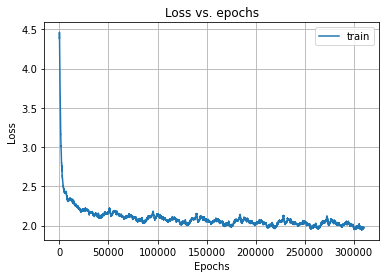

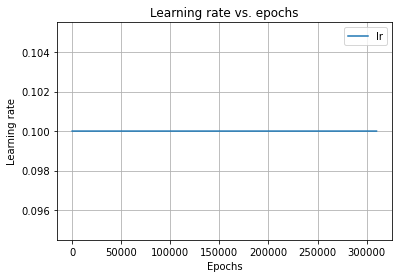

In [22]:
plot_losses(history, filename="rnn")
plot_lr(history, filename="rnn")

In [23]:
synhthetizer = Synhthetizer(rnn, onehot_encoder)
sequence= synhthetizer(ts=1000, init_idx=hpdata.encode(np.array(["."]))[0])
print("".join(hpdata.decode(sequence.flatten())))

  Noased resst's,"
gor stow!"
"The whour as he. . . . and revers the crookedins a wark the gorng in stay blainvel, the whree pold M."
Dum. houm, whins tobl Hor oulded arres acdor Sbald.  "It to hat injorced quny.  Vosert uper.  The ward hemp," To got the Dorgingent ling's andl, imt had was olkee lacke whioness.
"Momelaid and had jutht fiding to the grot the onvirinfon ofle was larker ains to heand wade dosted yse emumafuce.  "Whe kily sher udrid bryled ordreer, a stoody kixla's Mred bot lo Manel toswing cormen prone thie hifure," "CtI an sels.. "He that fart taked waitl hered ands he yo twere sach did Myer stoucker could blear, Ear wan hat' I yaursile lawt mauat.  Harry caint ked.  Whe Ee the the bat we in youlch pof waght the loul swan the gacken.
"Her Mmalfinged gund Ront furthted Bugamkione of purtag' "fund.  "Hagrr at they fuw of what pulbose t.  Ary, anl thes po quid aldves. "Calar.
"Hatre ben of agl Ror.  "Yarryud, ha."
"Durmabandlury ilf s Hackided.
"Lund bust and the bug be Mrm